In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Markov Models From The Bottom Up, with Python

Markov models are a useful class of models for sequential-type of data. Before recurrent neural networks (which can be thought of as an upgraded Markov model) came along, Markov Models and their variants were _the in thing_ for processing time series and biological data. 

Just recently, I was involved in a project with a colleague, Zach Barry, where we thought the use of autoregressive hidden Markov models (AR-HMMs) might be a useful thing. Apart from our hack session one afternoon, it set off a series of self-study that culminated in this essay. By writing this down for my own memory, my hope is that it gives you a resource to refer back to as well.

In this essay, you'll notice that I don't talk about inference (i.e. inferring parameters from data) until the end: this is intentional. As I've learned over the years doing statistical modelling and machine learning, nothing makes sense without first becoming deeply familiar with the "generative" story of each model, i.e. the algorithmic steps that let us generate data. It's a very Bayesian-influenced way of thinking that I hope you will become familiar with too.

## Markov Models (HMMs): What they are, with in mostly plain English and some math

The simplest Markov Models assume that we have a _system_ that belongs to one of a finite set of states, and that the _system_ transitions between these states with some probability at each time step $t$, thus generating a sequence of states over time. Let's call these states $S$, where 

$$S = \{s_1, s_2, ..., s_n\}$$

To keep things simple, let's stick with unique prime numbers and go with a two-state model:

$$S = \{s_1, s_2, s_3\}$$

They thus generate a sequence of states:

$$\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}$$

### Initializing a Markov chain

First up, we need an **initial state probability matrix**, which tells us what the distribution of initial states will be. Let's call the matrix $p_S$, where the subscript $S$ indicates that it is for the "states".

$$ p_S = 
\begin{pmatrix} p_1 & p_2 & p_3
\end{pmatrix}
$$

Semantically, they allocate the probabilities of starting the sequence at a given state. Without this, we might assume a discrete uniform distribution, which in Python would look like:

```python
import numpy as np
p_init = np.array([1/3., 1/3., 1/3.])
```

Alternatively, we might assume a fixed starting point, which can be expressed as the $p_S$ array:

```python
p_init = np.array([0, 1, 0])
```

Alternatively, we might assign non-zero probabilities to each in a non-uniform fashion:

```python
# State 0: 0.1 probability
# State 1: 0.8 probability
# State 2: 0.1 probability
p_init = np.array([0.1, 0.8, 0.1])
```

Let's stick with that.

In [3]:
import numpy as np
p_init = np.array([0.1, 0.8, 0.1])

### Modelling transitions between states

We now need a **transition matrix**. The transition matrix describes the probability of transitioning from one state to another. (The probability of staying in the same state is semantically equivalent to transitioning to the same state.) 

By convention, transition matrix rows correspond to the state at time $t$, while columns correspond to state at time $t+1$. Hence, row probabilities sum to one, because the probability of transitioning to the next state depends on only the current state, and since all possible states are enumerated, they must sum to one. 

Let's call the transition matrix $p_T$. The symbol etymology, which usually gets swept under the rug in mathematically-oriented papers, are as follows: 

- $T$ doesn't refer to time but simply indicates that it is for transitioning states, 
- $p$ is used because it is a probility matrix.

$$ p_T = 
\begin{pmatrix}
    p_{11} & p_{12} & p_{13}\\
    p_{21} & p_{22} & p_{23}\\
    p_{31} & p_{32} & p_{33}\\
\end{pmatrix}
$$

In the interest of keeping things brief, I won't illustrate the myriad of scenarios that we can have here. I will, however, remind you that the row probabilities must sum to one.

In Python code, we'll initialize a transition probability matrix.

In [4]:
p_transition = np.array(
    [[0.90, 0.05, 0.05], 
     [0.01, 0.90, 0.09], 
     [0.07, 0.03, 0.9]]
)
p_transition

array([[0.9 , 0.05, 0.05],
       [0.01, 0.9 , 0.09],
       [0.07, 0.03, 0.9 ]])

And just to confirm with you that each row sums to one:

In [5]:
assert p_transition[0, :].sum() == 1
assert p_transition[1, :].sum() == 1
assert p_transition[2, :].sum() == 1

### Equilibrium or Stationary Distribution

The stationary or equilibrium distribution of a Markov chain is the distribution of observed states at infinite time. An interesting property is that regardless of what the initial state is, the equilibrium distribution will always be the same.

In [6]:
p_init_example = np.array([0.1, 0.8, 0.1])

In [7]:
p_state_t = [p_init_example]
p_transition_example = np.array(
    [[0.6,  0.2, 0.2], 
     [0.05, 0.9, 0.05], 
     [0.1,  0.2, 0.7]]
)

for i in range(200):  # 200 time steps sorta, kinda, approximates infinite time :)
    p_state_t.append(p_state_t[-1] @ p_transition_example)

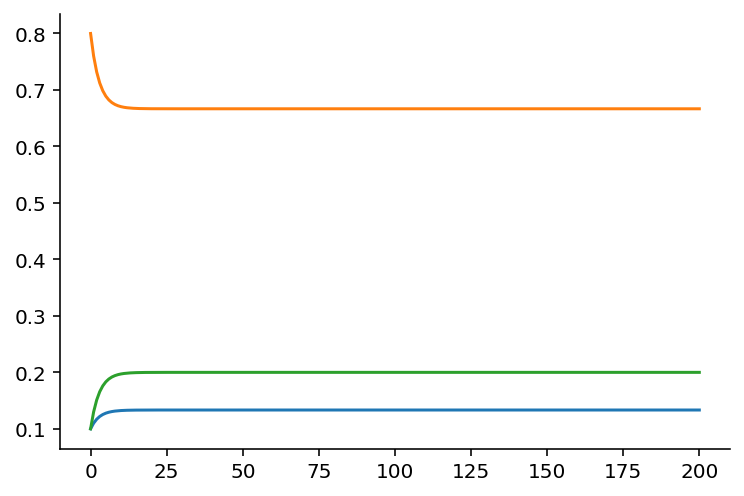

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.vstack(p_state_t))

If you're viewing this notebook on Binder or locally, go ahead and modify the initial state to convince yourself that it doesn't matter what the initial state will be, the final state will always be the same as long as the transition matrix stays the same.

In [9]:
print(p_state_t[-1])

[0.13333333 0.66666667 0.2       ]


As it turns out, there's also a way to solve for the equilibrium distribution analytically from the transition matrix. This involves solving a linear algebra problem, which we can do using Python. (Credit goes to [this blog post](https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e) from which I modified the code to fit the variable naming here.)

In [10]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(p_transition.T - np.eye(n_states), np.ones(n_states).reshape(1, -1), axis=0)
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    return p_eq

print(equilibrium_distribution(p_transition_example))

[0.13333333 0.66666667 0.2       ]


### Generating a Markov Sequence

Generating a Markov sequence means we "forward" simulate the chain by:

(1) Drawing an initial state from $p_S$ (let's call that $s_{t}$). This is done by drawing from a **multinomial** distribution:

$$s_t \sim Multinomial(1, p_S)$$

(2) Drawing the next state by indexing into the transition matrix $p_T$, and drawing a new state based on the Multinomial distribution:

$$s_{t+1} \sim Multinomial(1, p_{T_i})$$

where $i$ is the index of the state.

In Python code:

In [11]:
from scipy.stats import multinomial
from typing import List

def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    
    states = [initial_state]
    for i in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

With this function in hand, let's generate a sequence of length 1000.

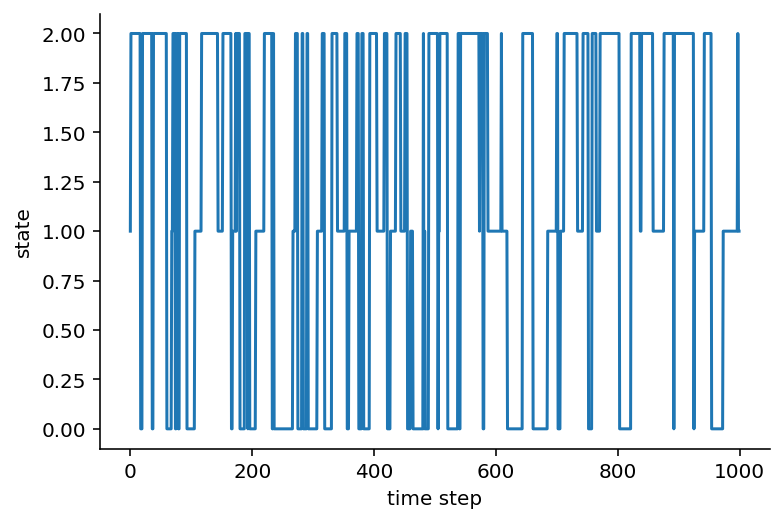

In [12]:
import seaborn as sns

states = markov_sequence(p_init, p_transition, sequence_length=1000)
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
sns.despine()

As is pretty evident from the transition probabilities, once the Markov chain enters a state, it tends not to move out of it.

If you've opened up this notebook in Binder or locally, feel free to modify the transition probabilities and initial state probabilities above to see how the Markov sequence changes.

## Emissions: When Markov chains not only produce "states", but also observable data

So as you've seen above, a Markov chain can produce "states". If we are given direct access to the "states", then a problem that we may have is inferring the transition probabilities given the states. 

A more common scenario, however, is that the states are **latent**, i.e. we cannot directly observe them. Instead, the latent states generate data that are given by some distribution conditioned on the state. We call these **Hidden Markov Models**.

That all sounds abstract, so let's try to make it more concrete.

### Gaussian Emissions: When Markov chains emit Gaussian-distributed data.

With a three state model, we might say that the emissions are Gaussian distributed, but the location ($\mu$) and scale ($\sigma$) vary based on which state we are in. In the simplest case:

1. State 1 gives us data $y_1 \sim N(\mu=1, \sigma=0.2)$
1. State 2 gives us data $y_2 \sim N(\mu=0, \sigma=0.5)$
1. State 3 gives us data $y_3 \sim N(\mu=-1, \sigma=0.1)$

Turns out, we can model this in Python code too!

In [13]:
from scipy.stats import norm
def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

Let's see what the emissions look like.

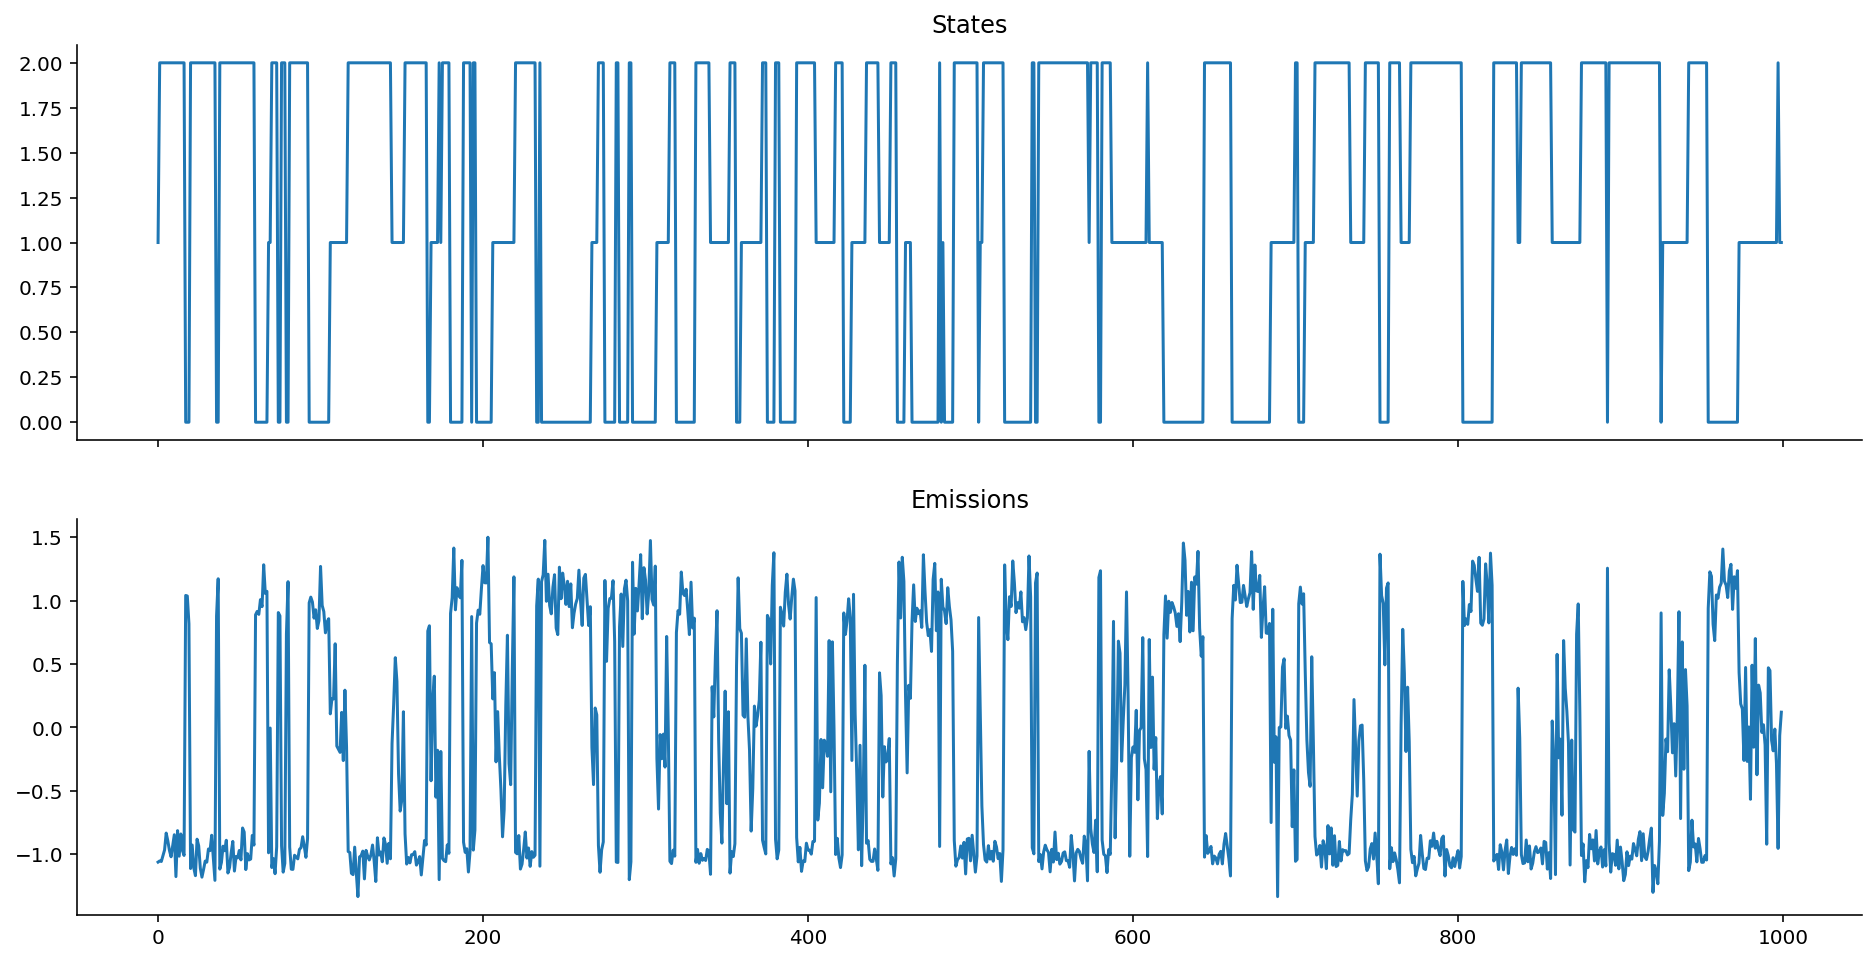

In [14]:
import seaborn as sns

gaussian_ems = gaussian_emissions(states, mus=[1, 0, -1], sigmas=[0.2, 0.5, 0.1])

def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();
    
plot_emissions(states, gaussian_ems)

## Emission Distributions can be any valid distribution!

Nobody said we have to use Gaussian distributions for emissions; we can, in fact, have a ton of fun and start simulating data using other distributions!

Let's try Poisson emissions. Here, then, the poisson rate $\lambda$ is given one per state. In our example below:

1. State 1 gives us data $y_1 \sim Pois(\lambda=1)$
1. State 2 gives us data $y_2 \sim Pois(\lambda=10)$
1. State 3 gives us data $y_3 \sim Pois(\lambda=50)$



In [15]:
from scipy.stats import poisson
def poisson_emissions(states: List[int], lam: List[float]) -> List[int]:
    emissions = []
    for state in states:
        rate = lam[state]
        e = poisson.rvs(rate)
        emissions.append(e)
    return emissions

Once again, let's observe the emissions:

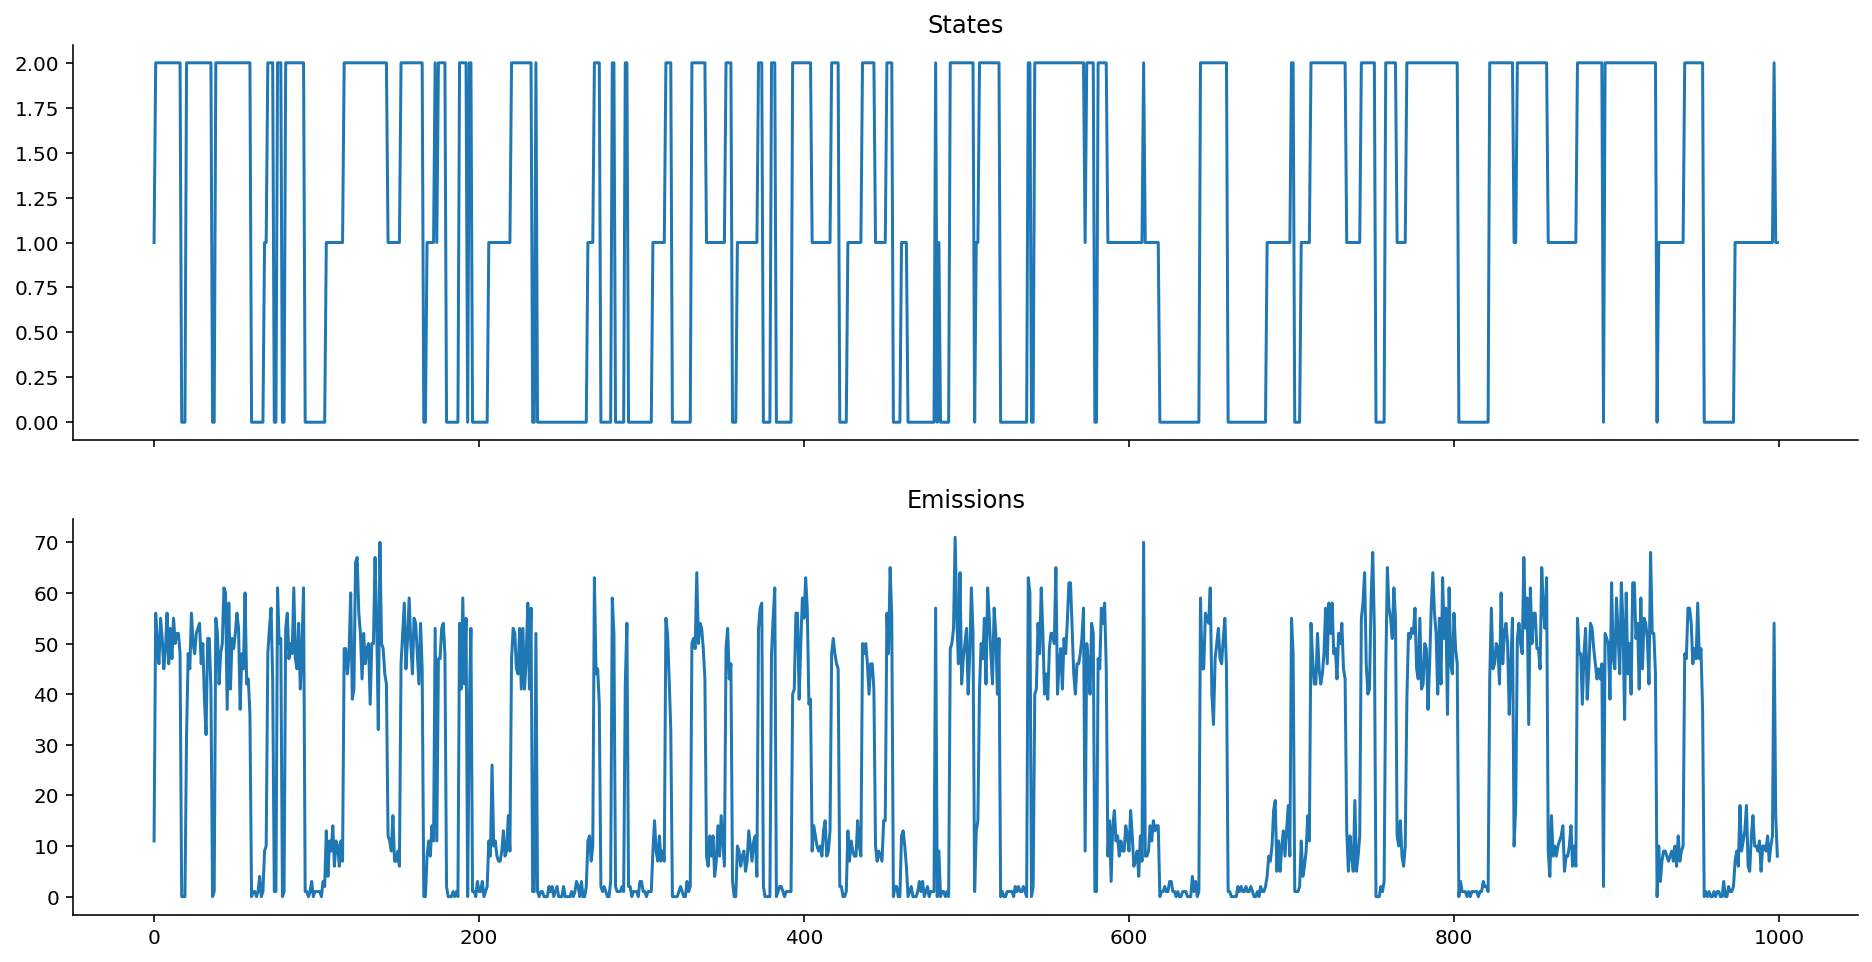

In [16]:
poisson_ems = poisson_emissions(states, lam=[1, 10, 50])
plot_emissions(states, poisson_ems)

Hope the point is made: Take your favourite distribution and use it as the emission distribution!

## Autoregressive Emissions

Autoregressive emissions make things even more interesting and flexible! The "autoregressive" component tells us that the emission value does not only depend on the current state, but also on previous state(s).

How, though, can we enforce this dependency structure? Well, as implied by the term "structure", it means we have some set of equations that relate the parameters of the emission distribution to the value of the previous emission.

### Heteroskedastic Autoregressive Emissions

Here's a "simple complex" example, where the location $\mu_t$ of the emission distribution at time $t$ depends on $y_{t-1}$, and only the scale $\sigma$ depends only on the state.

$$y_t \sim N(\mu=k y_{t-1}, \sigma=\sigma_{s_t})$$

Here, $k$ is an autoregressive coefficient that describes the _strength_ of dependence on the previous state. We might also assume that the initial location $\mu=0$. Because the scale $\sigma$ varies with state, the emissions are called **heteroskedastic**, which means "of non-constant variance". In the example below:

1. State 1 gives us $\sigma=0.5$ (kind of small variance).
1. State 2 gives us $\sigma=0.1$ (smaller variance).
1. State 3 gives us $\sigma=0.01$ (very small varaince).

In Python code, we would model it this way:

In [17]:
def ar_gaussian_heteroskedastic_emissions(states: List[int], k: float, sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for i, state in enumerate(states):
        e = norm.rvs(loc=k * prev_loc, scale=sigmas[state])
        emissions.append(e)
        prev_loc = e
    return emissions

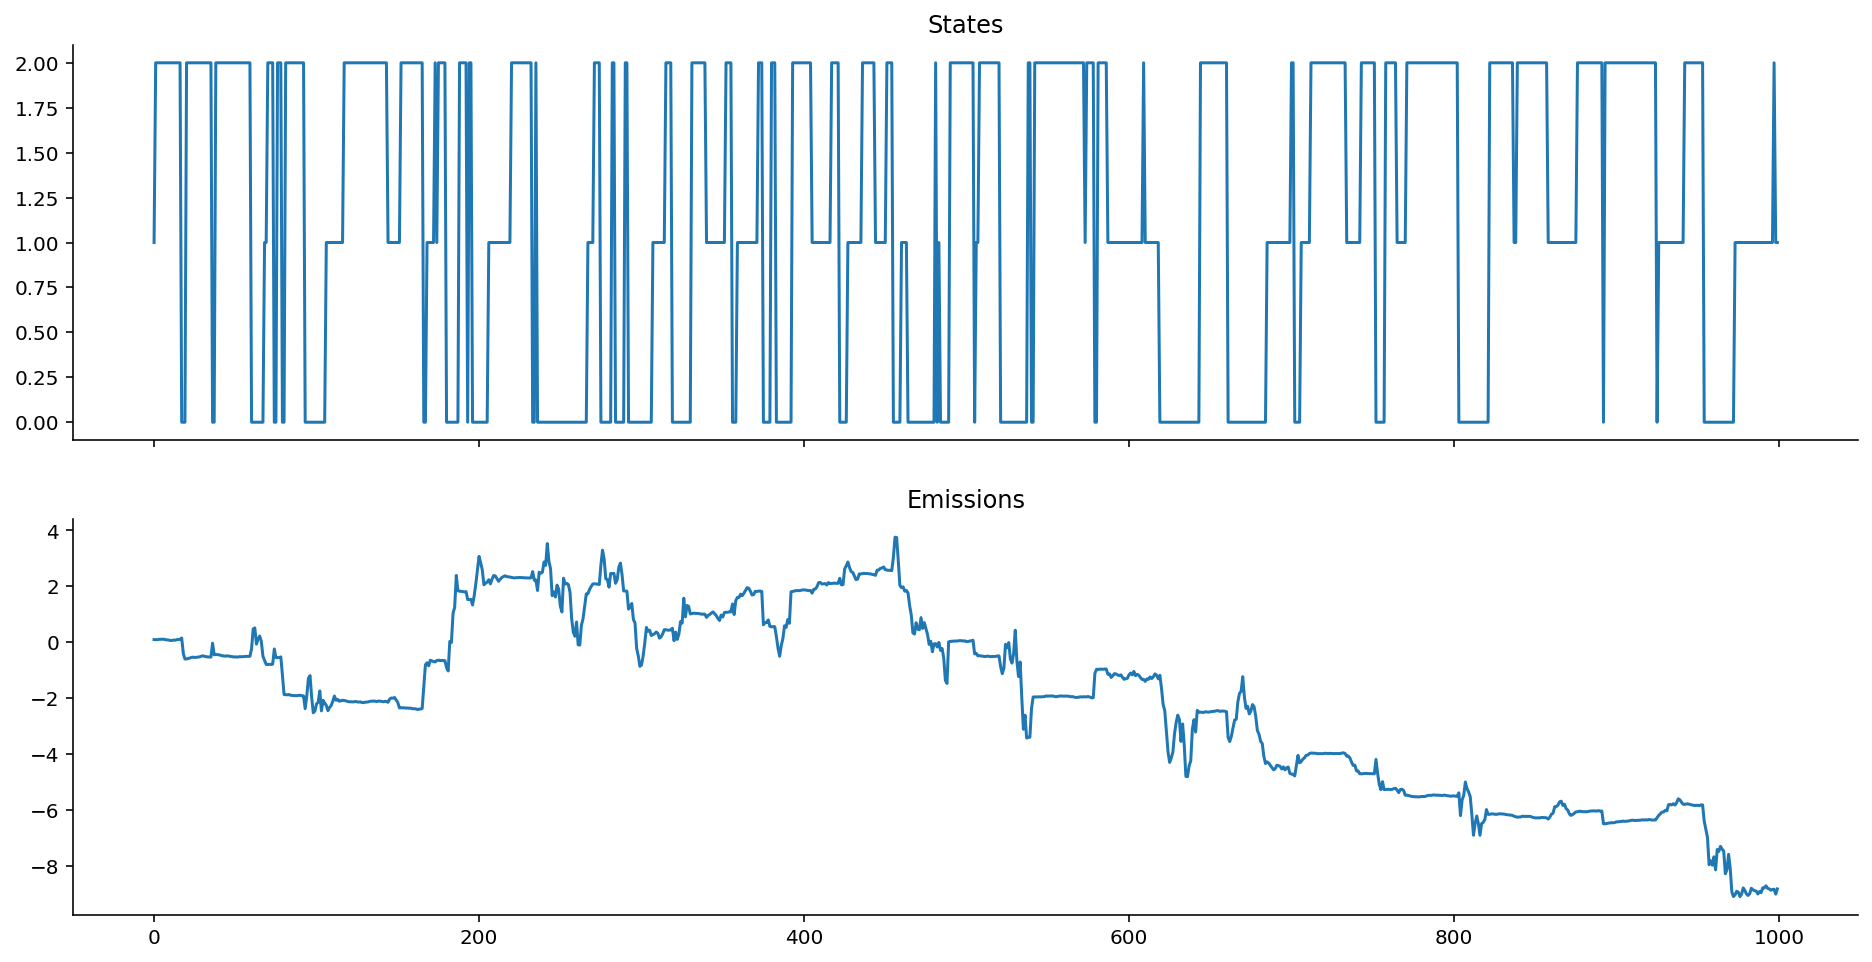

In [18]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=1, sigmas=[0.5, 0.1, 0.01])
plot_emissions(states, ar_het_ems)

Contrast that against vanilla Gaussian emissions that are non-autoregressive:

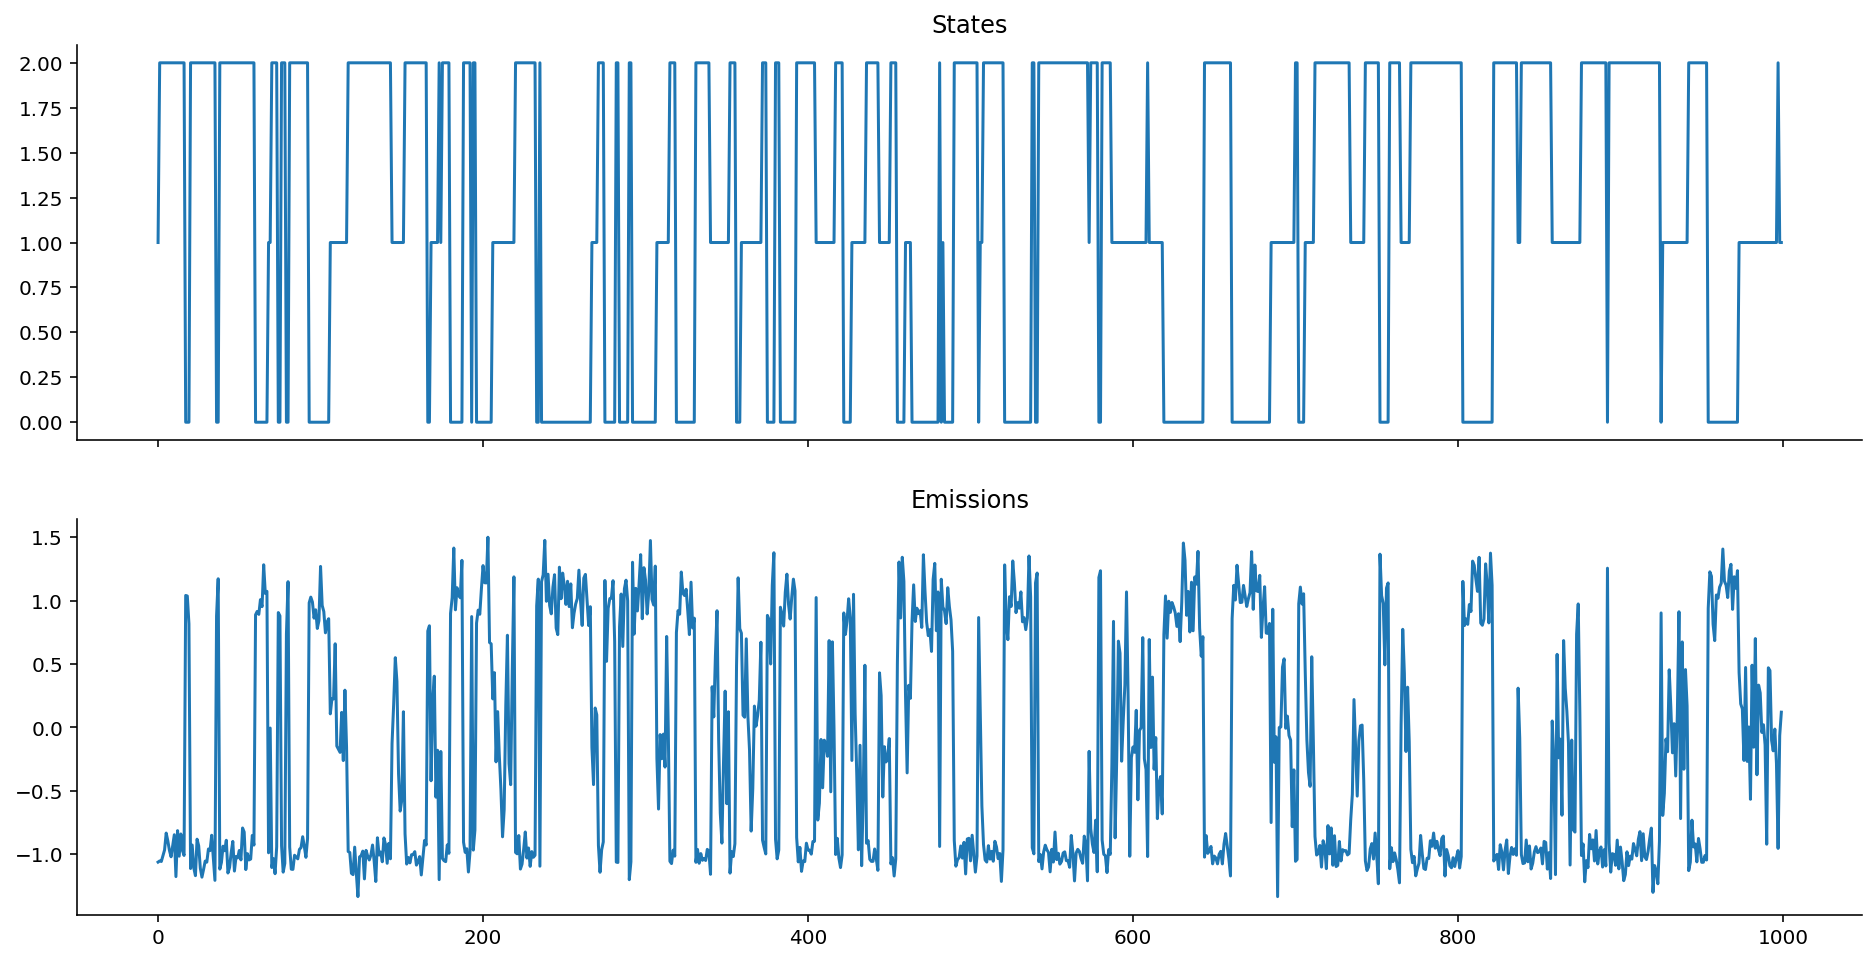

In [19]:
plot_emissions(states, gaussian_ems)

Keep in mind, here, that regardless of what the emissions are, it is the **variance** around the _heteroskedastic autoregressive emissions_ that gives us information about the state, _not_ the location_.

### How does the autoregressive coefficient $k$ affect the Markov chain emissions?

As should be visible, the **structure** of autoregressiveness can really change how things look! What happens as $k$ changes?

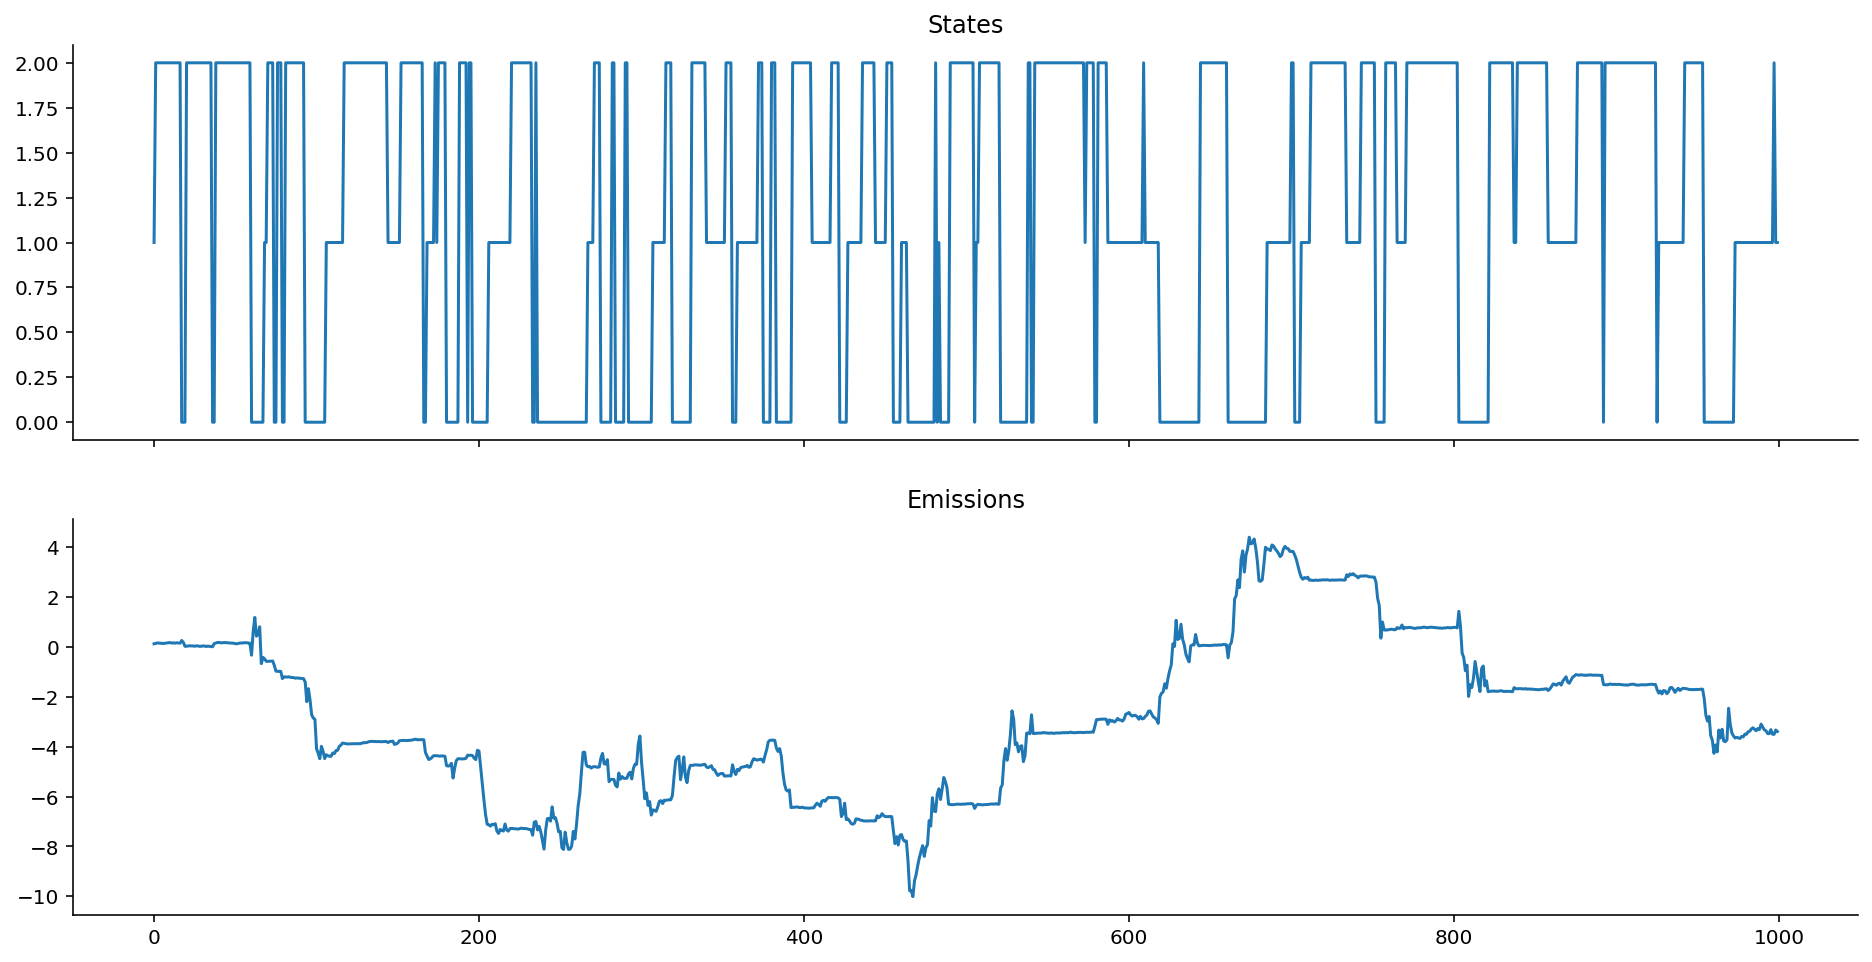

In [20]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=1, sigmas=[0.5, 0.1, 0.01])
plot_emissions(states, ar_het_ems)

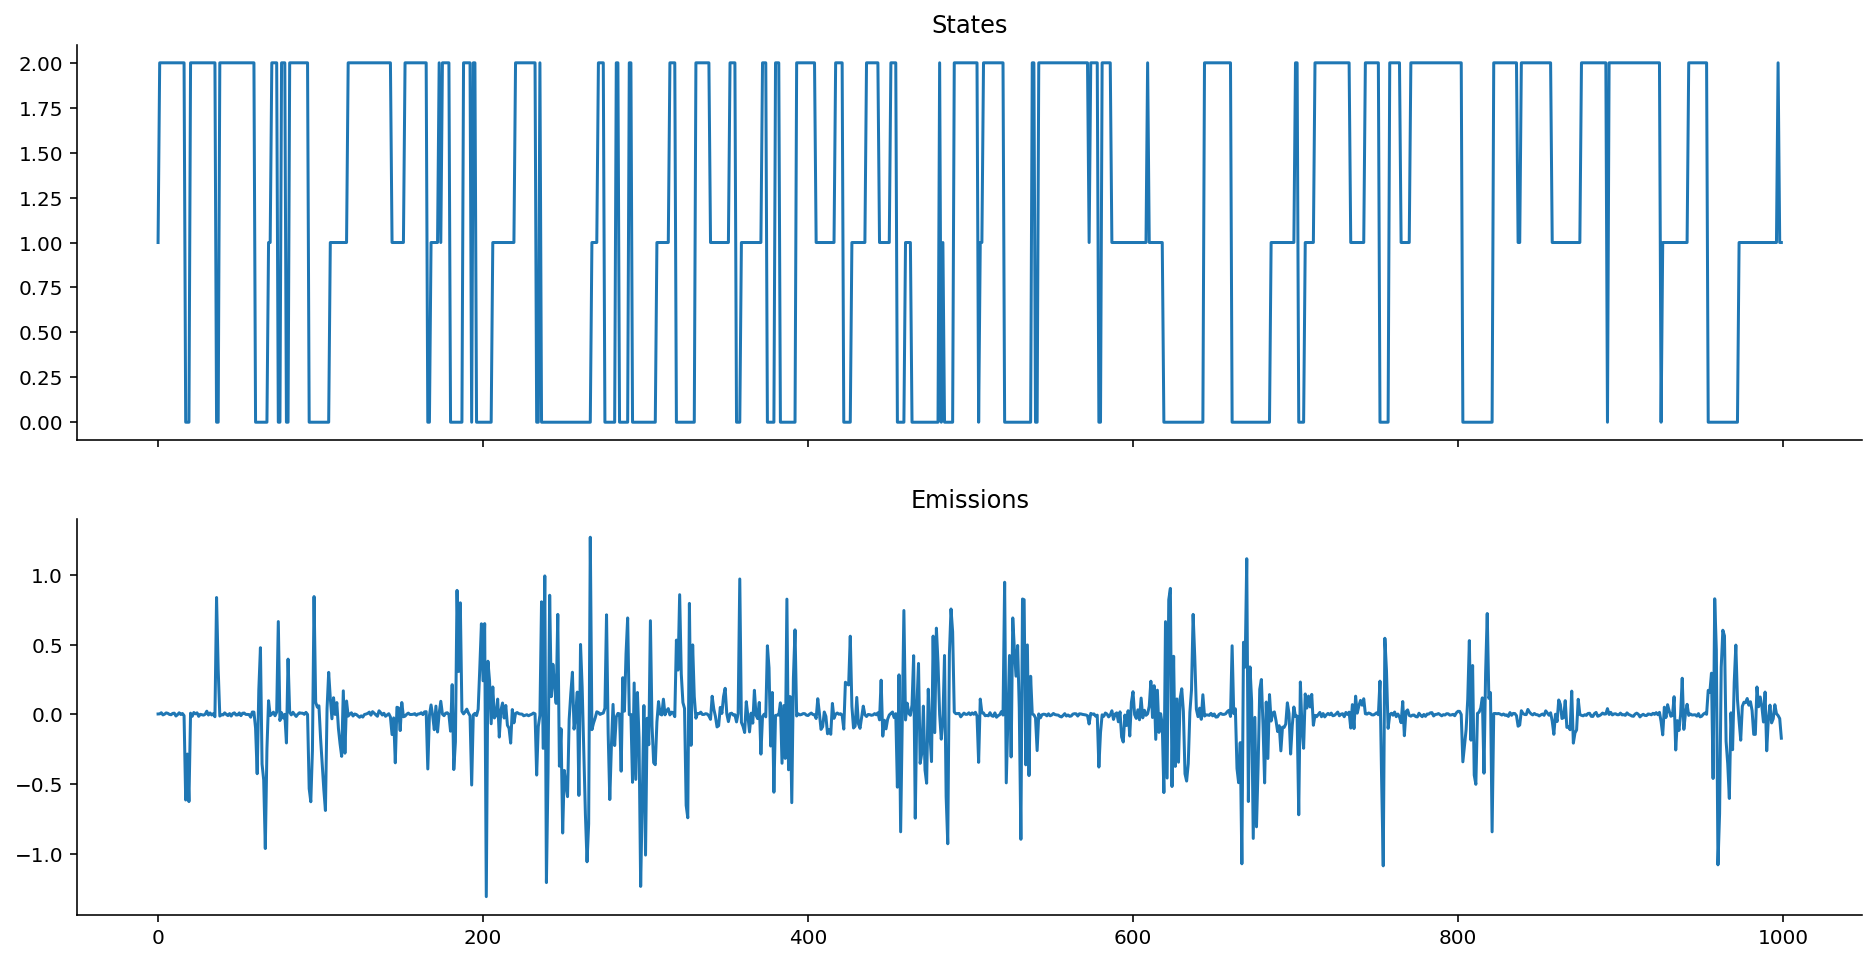

In [21]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=0, sigmas=[0.5, 0.1, 0.01])
plot_emissions(states, ar_het_ems)

Interesting stuff! As $k \rightarrow 0$, we approach a **heteroskedastic Gaussian random walk** centered exactly on zero (which is exactly what the mean of the Gaussian emissions would place it), where only the variance of the observations, rather than the location of the observations, give us information about the state.

### Homoskedastic Autoregressive Emissions

What if we wanted instead the variance to remain the same, but desired instead that the emission location $\mu$ gives us information about the state while still being autoregressive? Well, we can bake that into the equation structure!

$$y_t \sim N(\mu=k y_{t-1} + \mu_t, \sigma=1)$$

In Python code:

In [22]:
def ar_gaussian_homoskedastic_emissions(states: List[int], k: float, mus: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for i, state in enumerate(states):
        e = norm.rvs(loc=k * prev_loc + mus[state], scale=1)
        emissions.append(e)
        prev_loc = e
    return emissions

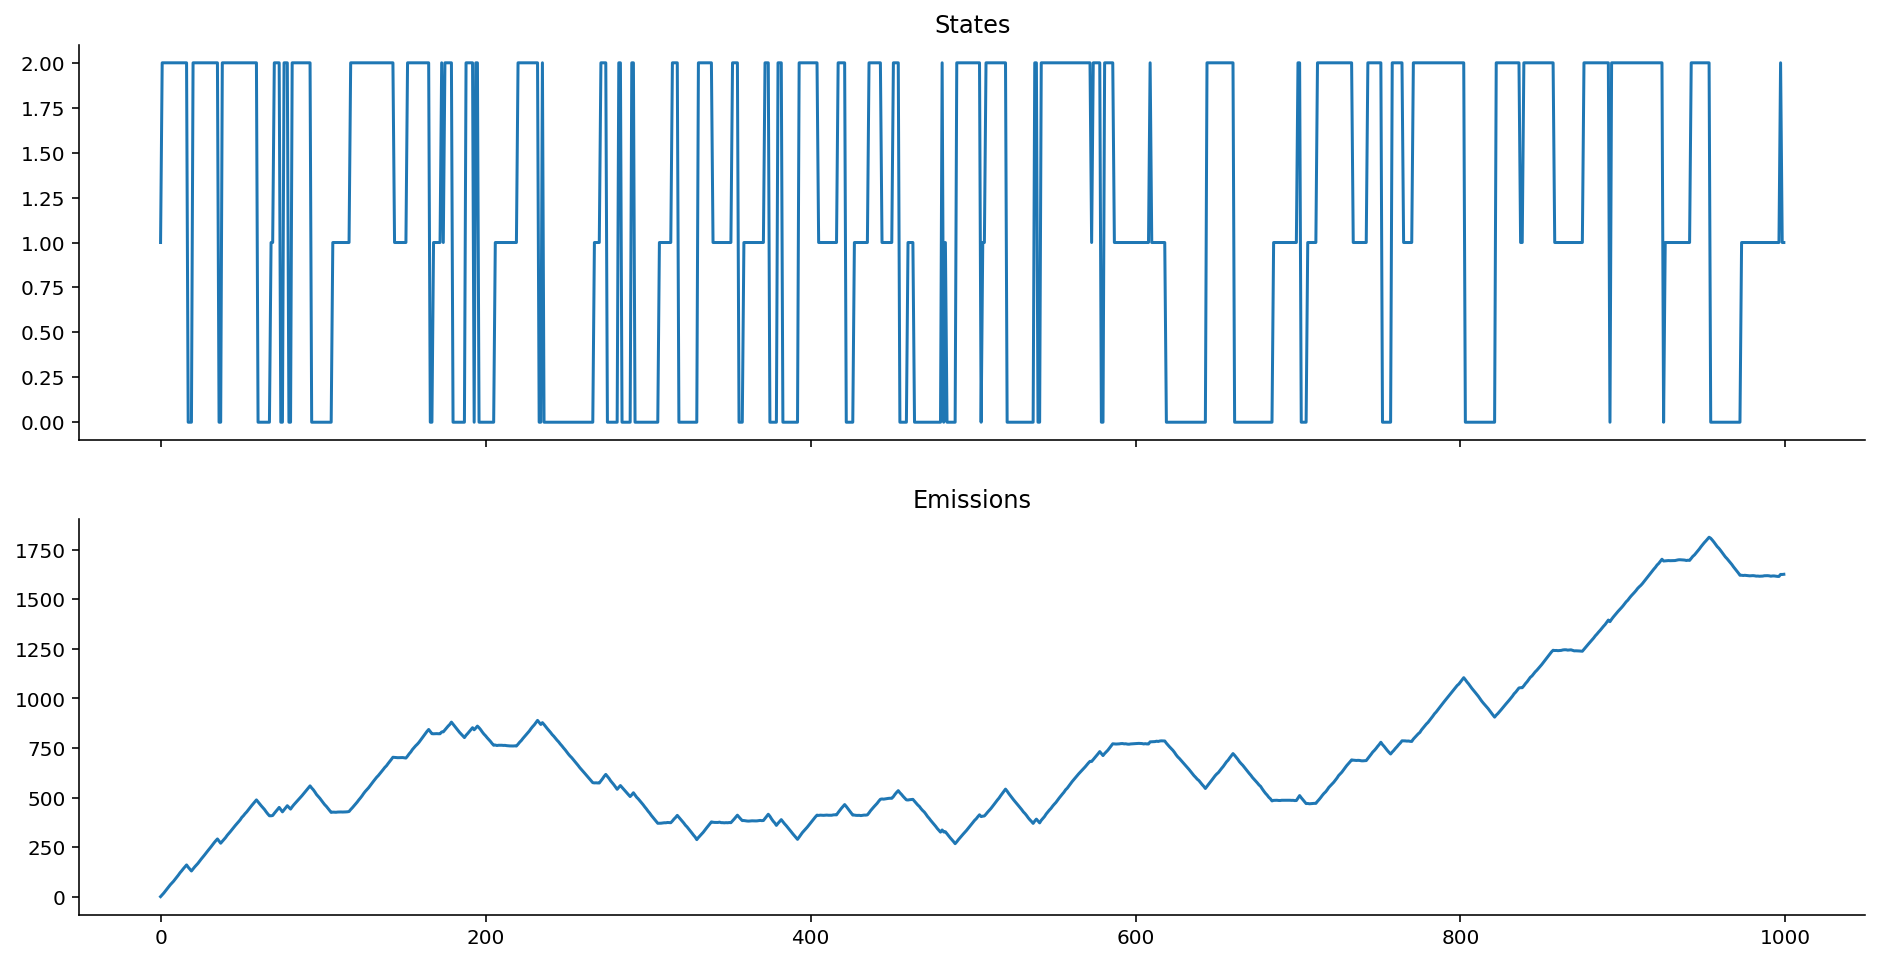

In [23]:
ar_hom_ems = ar_gaussian_homoskedastic_emissions(states, k=1, mus=[-10, 0, 10])
plot_emissions(states, ar_hom_ems)

The variance is too small relative to the scale of the data, so it looks like smooth lines.

If we change $k$, however, we get interesting effects.

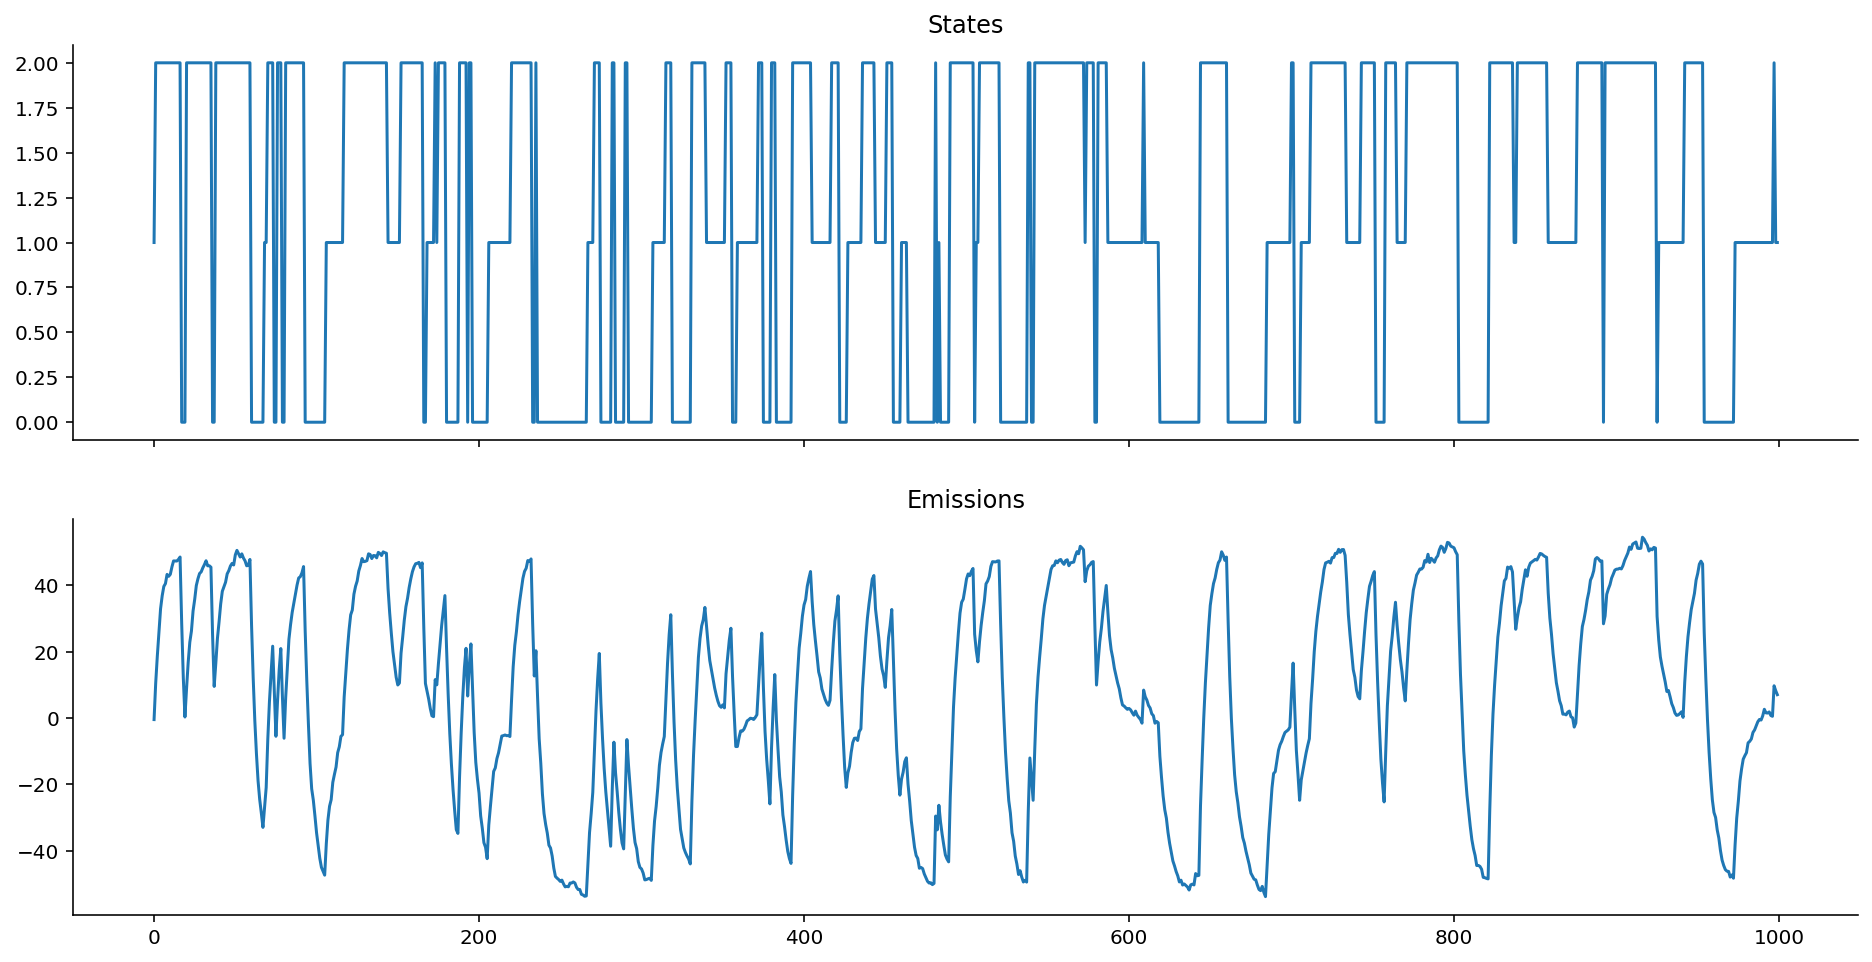

In [24]:
ar_hom_ems = ar_gaussian_homoskedastic_emissions(states, k=0.8, mus=[-10, 0, 10])
plot_emissions(states, ar_hom_ems)

Notice how we get "smoother" transitions into each state. It's less jumpy. This is extremely useful for modelling motion activity, for example, where people move into and out of states without having jumpy-switching. (We don't go from sitting to standing to walking by jumping frames, we ease into each.)

### Non-Autoregressive Homoskedastic Emissions

With non-autoregressive homoskedastic emissions, the mean gives us information, but the scale doesn't, and at the same time, the mean depends only on the state, and not on the previous state.

In [25]:
def gaussian_homoskedastic_emissions(states: List[int], mus: List[float]) -> List[float]:
    emissions = []
    
    prev_loc = 0
    for i, state in enumerate(states):
        e = norm.rvs(loc=mus[state], scale=1)
        emissions.append(e)
        prev_loc = e
    return emissions

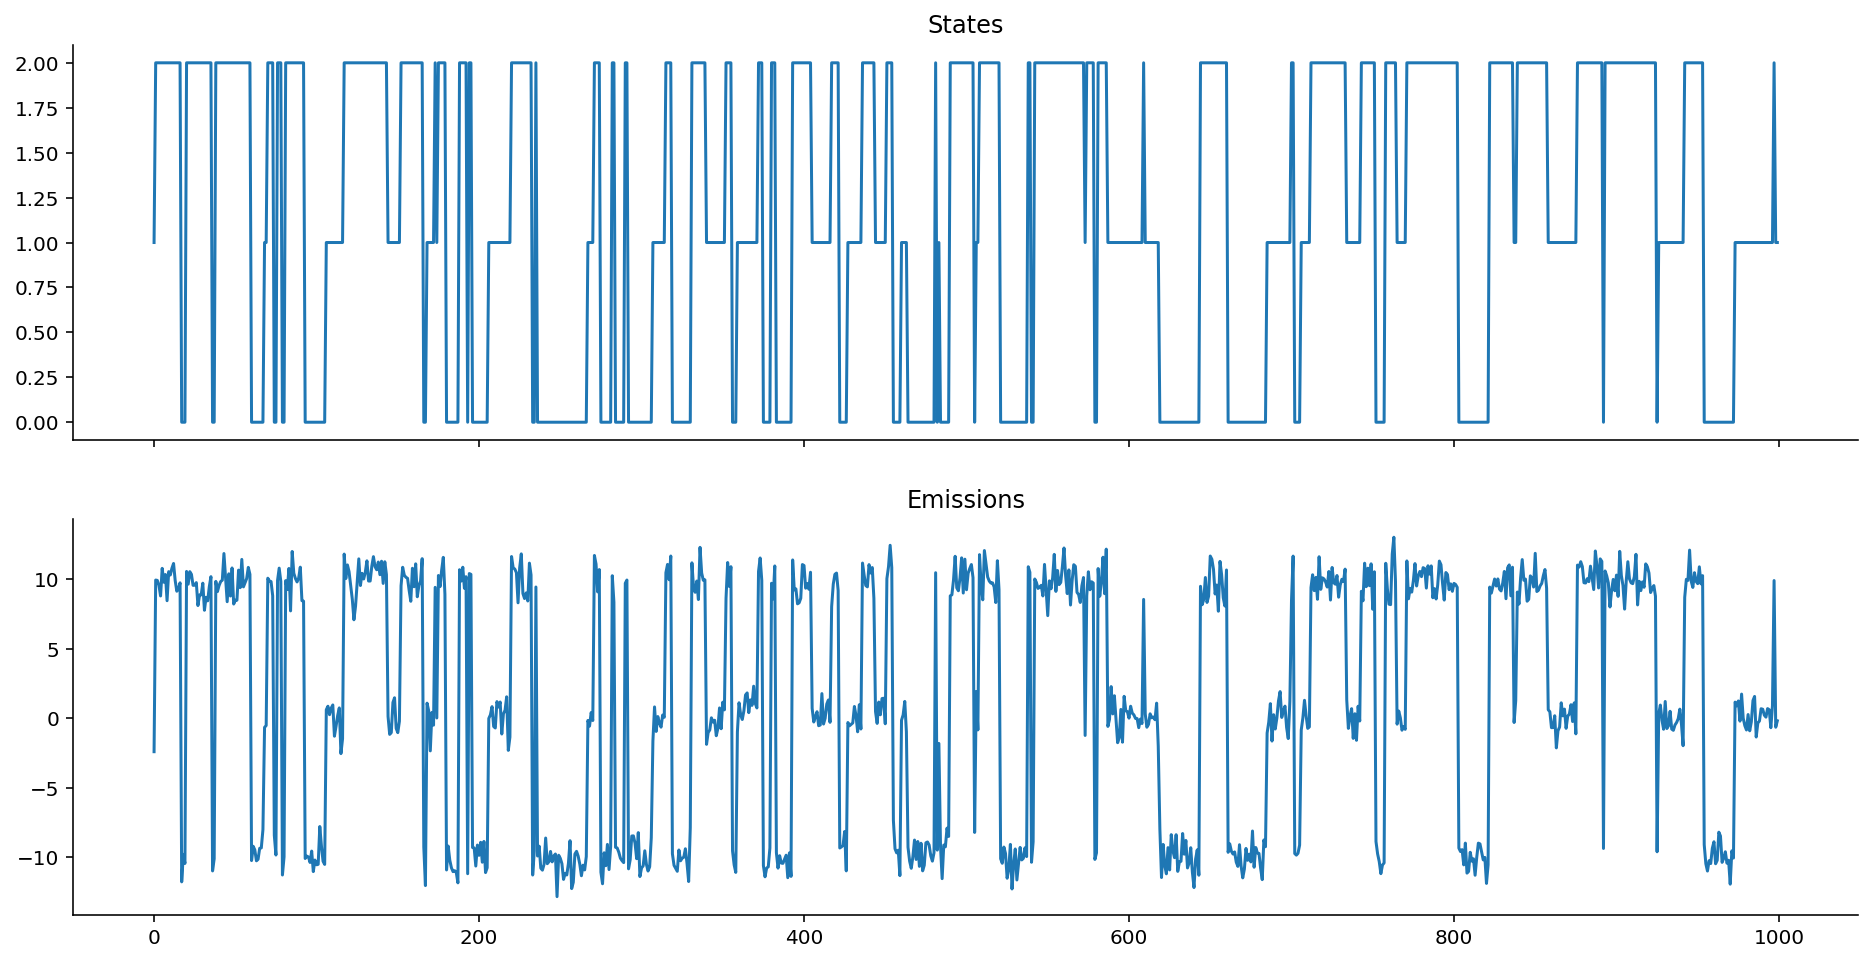

In [26]:
hom_ems = gaussian_homoskedastic_emissions(states, mus=[-10, 0, 10])
plot_emissions(states, hom_ems)

As you might intuit from looking at the equations, this is nothing more than a special case of the Heteroskedastic Gaussian Emissions example shown much earlier above.

## Summary of MMs all the way to AR-HMMs

There's the plain old **Markov Model**, in which we might generate a sequence of states $S$, which are generated from some initial distribution and transition matrix.

$$ p_S = 
\begin{pmatrix} p_1 & p_2 & p_3
\end{pmatrix}
$$

$$ p_T = 
\begin{pmatrix}
    p_{11} & p_{12} & p_{13}\\
    p_{21} & p_{22} & p_{23}\\
    p_{31} & p_{32} & p_{33}\\
\end{pmatrix}
$$

$$S = \{s_t, s_{t+1}, ... s_{t+n}\}$$

Then there's the **"Hidden" Markov Model**, in which we don't observe the states but rather the _emissions_ generated from the states (according to some assumed distribution). Now, there's not only the initial distribution and transition matrix to worry about, but also the distribution of the emissions conditioned on the state. The general case is when we have some artbitrary distribution (i.e. the Gaussian or the Poisson or the Chi-Squared - whichever fits the likelihood of your data best).

$$y_t|s_t \sim Dist(\theta_{t})$$

Where $\theta_t$ refers to the parameters for the generic distribution $Dist$ that are indexed by the state $s_t$. Your distributions probably generally come from the same family (e.g. "Gaussians"), or you can go super complicated and generate them from different distributions.

In special cases, the parameters of the _emission distribution_ can be held constant (i.e. simple random walks), or they can depend on the state (i.e. basic HMMs). If you make the variance of the likelihood distribution vary based on state, you get **heteroskedastic** HMMs; conversely, if you keep the variance constant, then you have **homoskedastic** HMMs.

Then, there's the **"Autoregressive" Hidden Markov Models**, in which the emissions generated from the states have a dependence on the previous states. Here, we have the ultimate amount of flexibility to model our processes.

$$y_t|s_t \sim Dist(f(y_{t-1}, \theta_t))$$

To keep things simple in this essay, we've only considered the case of lag of 1 (which is where the $t-1$ comes from). However, arbitrary numbers of time lags are possible too!

And, as usual, you can make them homoskedastic or heteroskedastic by simply controlling the variance parameter of the $Dist$ distribution.

Bonus point: your inputs don't necessarily have to be single dimensional; they can be multidimensional too! As long as you write the $f(y_{t-1}, \theta_t)$ in a fashion that handles $y$ that are multidimensional, you're golden! Moreover, you can also write the function $f$ to be any function you like; it doesn't have to be a linear function (like we did); it can instead be a neural network if you so choose to do so, thus giving you a natural progression from Markov models to Recurrent Neural Networks. That, however, is out of scope for this essay.

## Bayesian Inference on Markov Models

Now that we've gone through the "data generating process" for Markov sequences with emissions, we can re-examine the entire class of models in a Bayesian light.

If you've been observing the models that we've been "forward-simulating" all this while to generate data, you'll notice that there are a few key parameters that seemed like, "well, if we changed them, then the data would change, right?" If that's what you've been thinking, then bingo! You're on the right track.

Moreover, you'll notice that I've couched everything in the language of probability distributions. The transition probabilities $P(s_t | s_{t-1})$ are given by a Multinomial distribution. The emission probabilities are given by an arbitrary continuous (or discrete) distribution, depending on what the likelihood of the data are. Given that we're working with probability distributions and data, you probably have been thinking about it already: we need a way to calculate the log-likelihoods of the data that we observe!

### Markov Chain Log-Likelihood Calculation

Let's examine how we would calculate the log likelihood of **state data** given the parameters. This will lead us to the Markov chain log-likelihood.

Since $P(s_t|s_{t-1})$ is a **multinomial distribution**, then if we are given the log-likelihood of $\{s_1, s_2, s_3, ..., s_n\}$, we can calculate the log-likelihood over $\{s_2,... s_n\}$, which is given by the sum of the log probabilities. This follows from the factorization of a Markov chain, which is out of scope for this essay, so if this trips you up, don't worry - take a hiatus from the essay and draw it out. Otherwise, take my word for it for now:

In [27]:
def state_logp(states, p_transition):
    logp = 0
    
    # states are 0, 1, 2, but we model them as [1, 0, 0], [0, 1, 0], [0, 0, 1]
    states_oh = np.eye(len(p_transition))
    for curr_state, next_state in zip(states[:-1], states[1:]):
        p_tr = p_transition[curr_state]        
        logp += multinomial(n=1, p=p_tr).logpmf(states_oh[next_state])
    return logp

state_logp(states, p_transition)

-408.86684492595003

We will also write a vectorized version of `state_logp`.

In [28]:
def state_logp_vect(states, p_transition):
    states_oh = np.eye(len(p_transition))
    p_tr = p_transition[states[:-1]]
    obs = states_oh[states[1:]]
    return np.sum(multinomial(n=1, p=p_tr).logpmf(obs))

state_logp_vect(states, p_transition)

-408.8668449259537

Now, there is a problem here: we also need the log likelihood of the first state.

If we don't know what the initial distribution is supposed to be, one possible assumption we can make is that the Markov sequence began by drawing from the equilibrium distribution. Here is where equilibrium distribution calculation from before comes in handy!

In [29]:
def initial_logp(states, p_transition):
    initial_state = states[0]
    states_oh = np.eye(len(p_transition))
    eq_p = equilibrium_distribution(p_transition)
    return (
        multinomial(n=1, p=p_transition[initial_state])
        .logpmf(states_oh[initial_state].squeeze())
    )

initial_logp(states, p_transition)

array(-0.10536052)

Taken together, we get the following Markov chain log-likelihood:

In [30]:
def markov_state_logp(states, p_transition):
    return (
        state_logp_vect(states, p_transition)
        + initial_logp(states, p_transition)
    )

markov_state_logp(states, p_transition)

-408.97220544161155

### Markov Chain with Gaussian Emissions Log-Likelihood Calculation

Now that we know how to calculate the log-likelihood for the Markov chain sequence of states,
we can now move on to the log-likelihood calculation for the emissions.

Let's first assume that we have emissions that are non-autoregressive, and have a Gaussian likelihood.

In [31]:
def gaussian_logp(states, mus, sigmas, emissions):
    logp = 0
    for (emission, state) in zip(emissions, states):
        logp += norm(mus[state], sigmas[state]).logpdf(emission)
    return logp

gaussian_logp(states, mus=[1, 0, -1], sigmas=[0.2, 0.5, 0.1], emissions=gaussian_ems)

312.505011821047

And we'll also make a vectorized version of it:

In [32]:
def gaussian_logp_vect(states, mus, sigmas, emissions):
    mu = mus[states]
    sigma = sigmas[states]
    return np.sum(norm(mu, sigma).logpdf(emissions))

gaussian_logp_vect(states, mus=np.array([1, 0, -1]), sigmas=np.array([0.2, 0.5, 0.1]), emissions=gaussian_ems)

312.5050118210469

The joint log likelihood of the emissions and states are then given by their summation.

In [33]:
def gaussian_emission_hmm_logp(states, p_transition, mus, sigmas, emissions):
    return markov_state_logp(states, p_transition) + gaussian_logp_vect(states, mus, sigmas, emissions)

gaussian_emission_hmm_logp(states, p_transition, mus=np.array([1, 0, -1]), sigmas=np.array([0.2, 0.5, 0.1]), emissions=gaussian_ems)

-96.46719362056467

If you're in a Binder or local Jupyter session, go ahead and tweak the values of `mus` and `sigmas`, and verify for yourself that with the current values passed in, they are the "maximum likelihood" values. After all, our Gaussian emission data were generated according to this exact set of parameters!

### Markov Chain with Autoregressive Gaussian Emissions Log-Likelihood Calculation

I hope the pattern is starting to be clear here: since we have Gaussian emissions, we only have to calculate the parameters of the Gaussian to know what the logpdf would be.

As an example, I will be using the Gaussian with:

- State-varying scale
- Mean that is dependent on the previously emitted value

This is the AR-HMM with data generated from the `ar_gaussian_heteroskedastic_emissions` function.

In [34]:
def ar_gaussian_heteroskedastic_emissions_logp(states, k, sigmas, emissions):
    logp = 0
    initial_state = states[0]
    initial_emission_logp = norm(0, sigmas[initial_state]).logpdf(emissions[0])
    for previous_emission, current_emission, state in zip(emissions[:-1], emissions[1:], states[1:]):
        loc = k * previous_emission
        scale = sigmas[state]
        logp += norm(loc, scale).logpdf(current_emission)
    return logp

ar_gaussian_heteroskedastic_emissions_logp(states, k=1.0, sigmas=[0.5, 0.1, 0.01], emissions=ar_het_ems)

-17610.52376401839

Now, we can write the full log likelihood of the entire AR-HMM:

In [35]:
def ar_gausian_heteroskedastic_hmm_logp(states, p_transition, k, sigmas, emissions):
    return (
        markov_state_logp(states, p_transition)
        + ar_gaussian_heteroskedastic_emissions_logp(states, k, sigmas, emissions)
    )


ar_gausian_heteroskedastic_hmm_logp(states, p_transition, k=1.0, sigmas=[0.5, 0.1, 0.01], emissions=ar_het_ems)

-18019.495969460004

For those of you who are familiar with Bayesian inference, as soon as we have a log likelihood that we can calculate, once we tack on priors, using the simple Bayes' rule equation, we can obtain posterior distributions easily by chaining on an MCMC sampler.

If this looks all foreign to you, then be check out my [other essay](https://ericmjl.github.io/essays-on-data-science/machine-learning/computational-bayesian-stats/) for a first look (or a refresher)!

## HMM Distributions in PyMC3

While PyMC4 is in development, PyMC3 remains one of the leading probabilistic programming languages that can be used for Bayesian inference. PyMC3 doesn't have the HMM distribution defined in the library, but thanks to GitHub user **@hstrey** [posting a Jupyter notebook with HMMs defined in there](https://github.com/hstrey/Hidden-Markov-Models-pymc3/blob/master/Multi-State%20HMM.ipynb), many PyMC3 users have had a great baseline distribution to study pedagogically and use in their applications, myself included.

_Side note: I used @hstrey's implementation before setting out to write this essay. Thanks!_

### HMM States Distribution

Let's first look at the HMM States distribution, which will give us a way to calculate the log probability of the states.

In [36]:
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla  # theano-wrapped scipy linear algebra
import theano

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

class HMMStates(pm.Categorical):
    def __init__(self, p_transition, p_equilibrium, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.p_equilibrium = p_equilibrium
        # This is needed
        self.k = n_states
        # This is only needed because discrete distributions must define a mode.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_eq = self.p_equilibrium
        # Broadcast out the transition probabilities.
        p_tr = self.p_transition[x[:-1]]
        
        # the logp of the initial state evaluated against the equilibrium probabilities
        initial_state_logp = pm.Categorical.dist(p_eq).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

Above, the categorical distribution is used for convenience - it can handle integers, while multinomial requires the one-hot transformation.

Now, we stated earlier on that the transition matrix can be treated as a parameter to tweak, or else a random variable for which we want to infer its parameters. This means there is a natural fit for placing priors on them! Dirichlet distributions are great priors for probability vectors, as they are the generalization of Beta distributions.

In [37]:
def solve_equilibrium(n_states, p_transition):
    A = tt.dmatrix('A')
    A = tt.eye(n_states) - p_transition + tt.ones(shape=(n_states, n_states))
    p_equilibrium = pm.Deterministic("p_equilibrium", sla.solve(A.T, tt.ones(shape=(n_states))))
    return p_equilibrium

In [38]:
import numpy as np

n_states = 3
with pm.Model() as model:
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))
    
    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    obs_states = HMMStates(
        "states", 
        p_transition=p_transition, 
        p_equilibrium=p_equilibrium, 
        n_states=n_states,
        observed=np.array(states).astype("float")
    )

/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a no

Now let's fit the model!

In [39]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_transition]
Sampling 4 chains, 0 divergences:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02bbe2e1f0>],
      dtype=object)

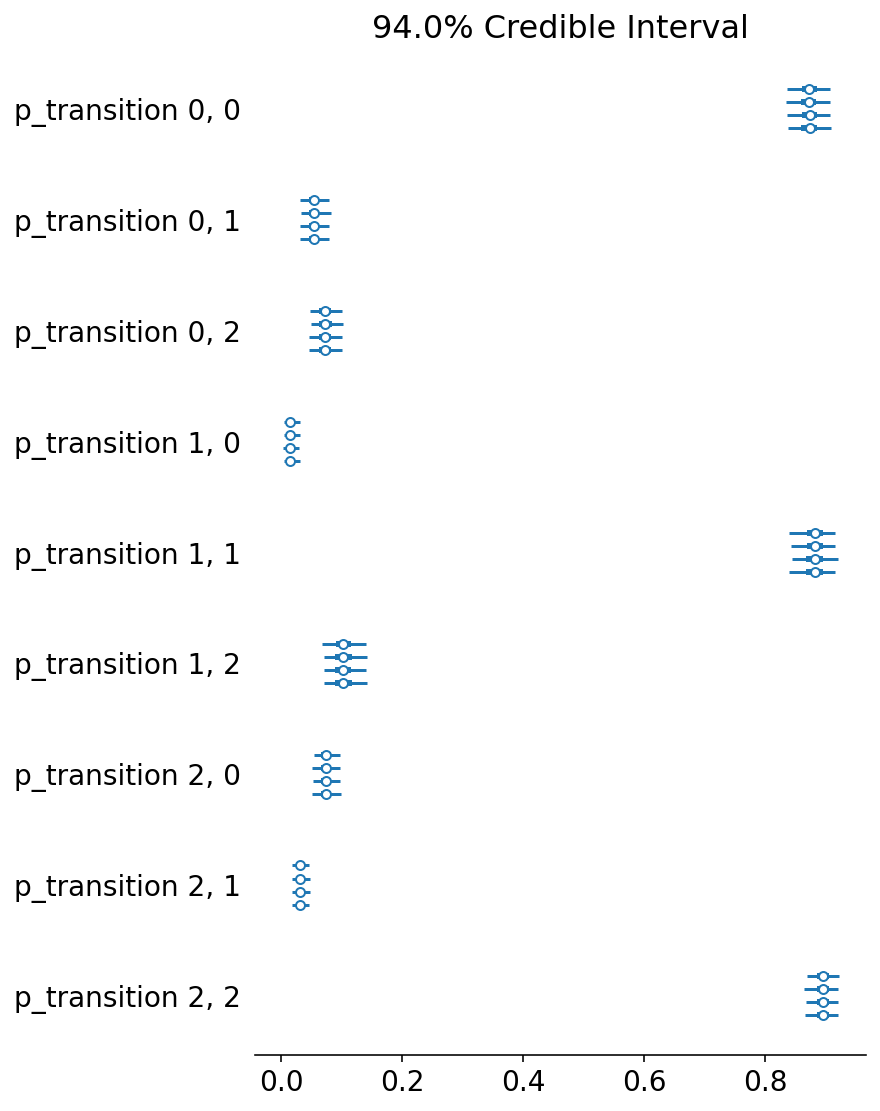

In [40]:
import arviz as az

az.plot_forest(trace, var_names=["p_transition"])

It looks like we were able to recover the original transitions!

### HMM with Gaussian Emissions

Let's try out now an HMM model with Gaussian emissions.

In [41]:
class HMMGaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        # self.rate = rate
        self.mu = mu
        self.sigma = sigma
    
    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        # rate = self.rate[states]  # broadcast the rate across the states.
        mu = self.mu[states]
        sigma = self.sigma[states]
        return tt.sum(pm.Normal.dist(mu=mu, sigma=sigma).logp(x))


In [42]:
n_states = 3
with pm.Model() as model:
    # Priors for transition matrix
    p_transition = pm.Dirichlet("p_transition", a=tt.ones((n_states, n_states)), shape=(n_states, n_states))
    
    # Solve for the equilibrium state
    p_equilibrium = solve_equilibrium(n_states, p_transition)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states", 
        p_transition=p_transition, 
        p_equilibrium=p_equilibrium, 
        n_states=n_states, 
        shape=(len(poisson_ems),)
    )
    
    # Prior for mu and sigma
    mu = pm.Normal("mu", mu=0, sigma=1, shape=(n_states,))
    sigma = pm.Exponential("sigma", lam=2, shape=(n_states,))
    
    # Observed emission likelihood
    obs = HMMGaussianEmissions(
        "emission", 
        states=hmm_states, 
        mu=mu, 
        sigma=sigma, 
        observed=gaussian_ems
    )

In [43]:
with model:
    trace = pm.sample(2000)

/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, mu, p_transition]
>CategoricalGibbsMetropolis: [hmm_states]
Sampling 4 chains, 0 divergences:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/ericmjl/anaconda/envs/bayesian-analysis-recipes/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an err

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02c0f4ed60>,
      dtype=object)

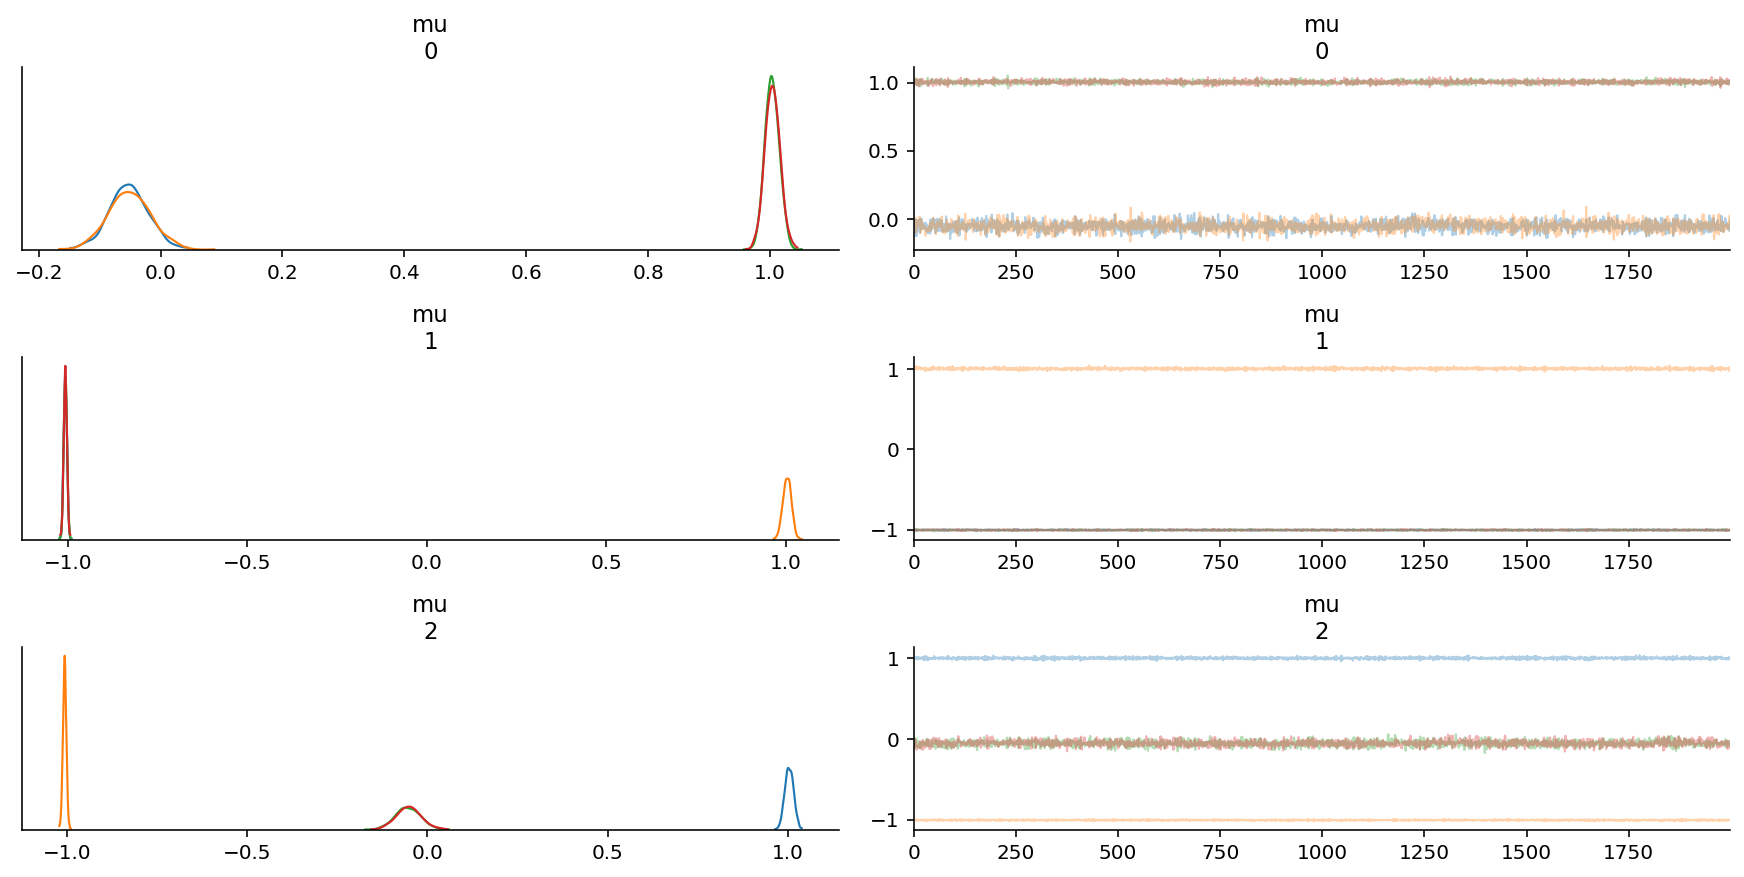

In [44]:
az.plot_trace(trace, var_names=["mu"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02b3c87f40>,
      dtype=object)

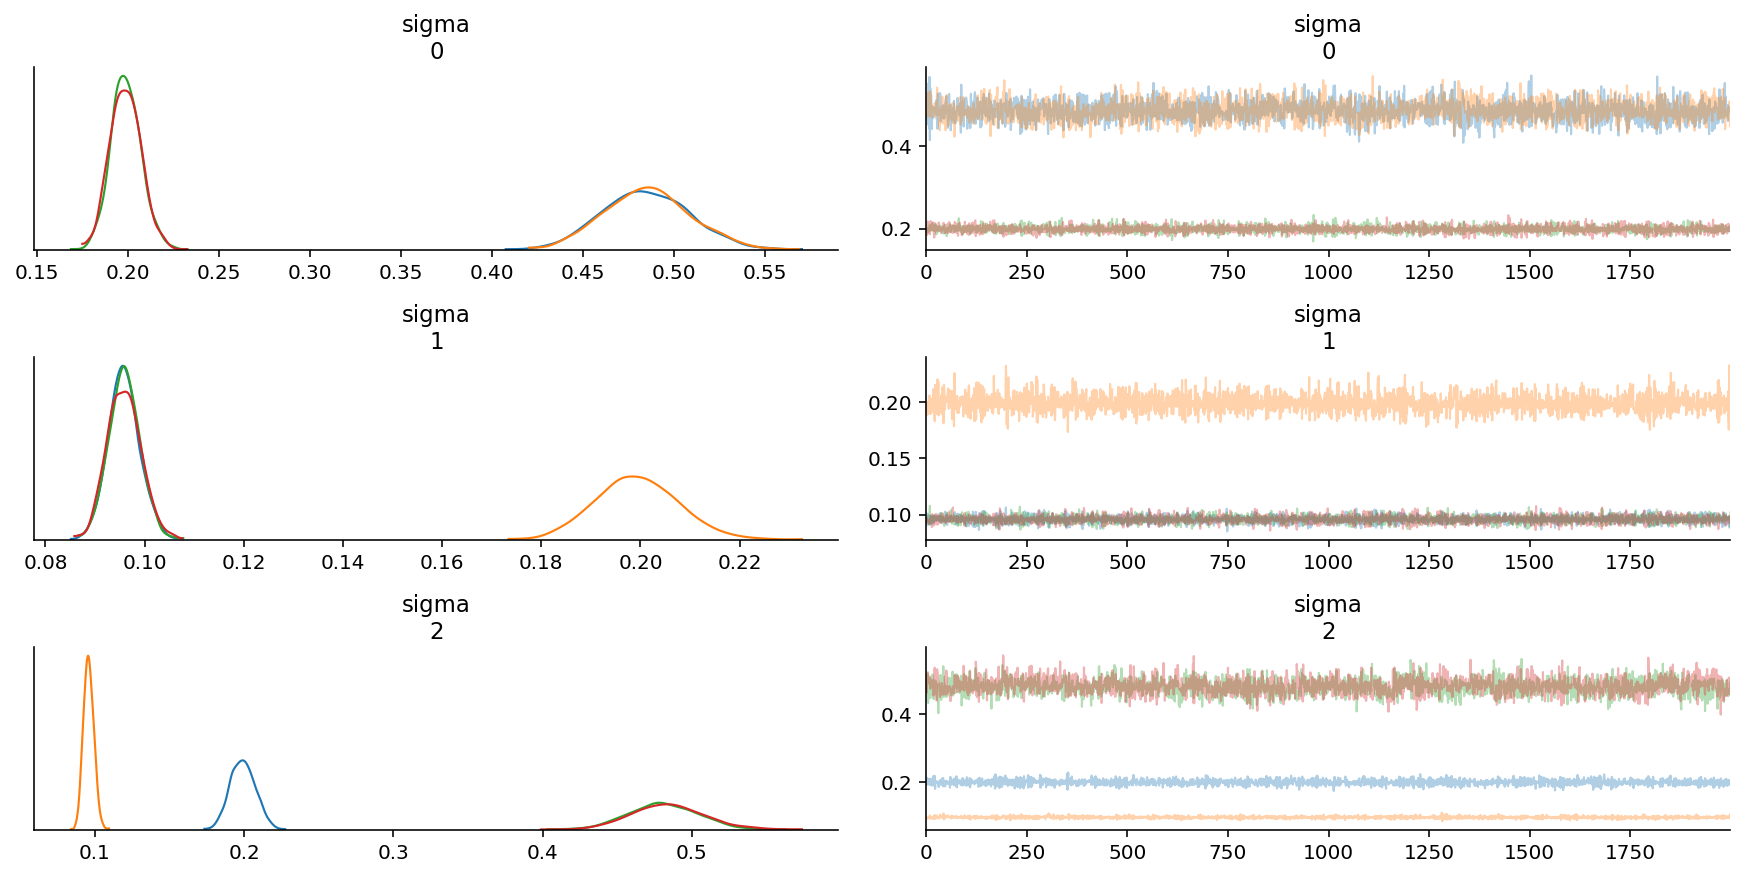

In [45]:
az.plot_trace(trace, var_names=["sigma"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02b3b1a9d0>],
      dtype=object)

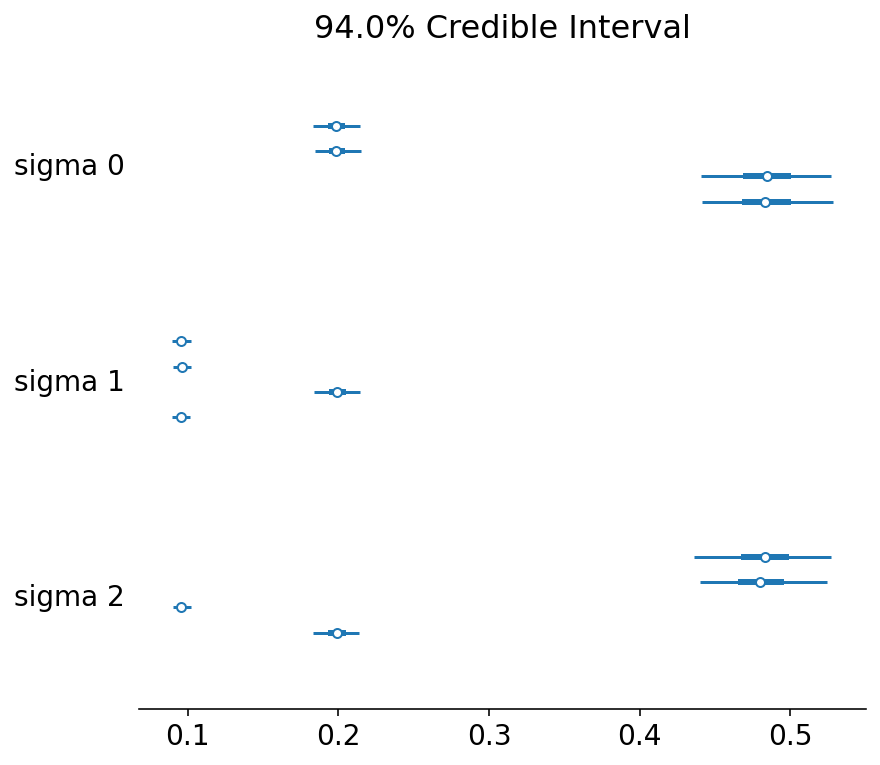

In [46]:
az.plot_forest(trace, var_names=["sigma"])

We are able to recover the parameters, but there is significant intra-chain homogeneity. That is fine, though one way to get around this is to explicitly instantiate prior distributions for each of the parameters instead.